- Demander chenling si que parents parents

- 

In [20]:
import torch

from anndata import read_h5ad
import pandas as pd
import pickle as pkl
import os
import numpy as np

from scvi.dataset import SyntheticDataset, AnnDatasetFromAnnData
from scvi.inference import SemiSupervisedTrainer

from scvi.models import SCANVI
from scvi import set_seed

set_seed(0)
use_cuda = True

DATA_PATH = "/data/yosef2/users/pierreboyeau/scVI_TSP/hier_data"

ontology_dict = pd.read_pickle(os.path.join(DATA_PATH, "ontology_dict.pkl"))
with open(os.path.join(DATA_PATH, "adjm.pkl"), "rb") as f:
    adjm = pkl.load(f)
combined = read_h5ad(os.path.join(DATA_PATH, "anndata.h5"))


def get_leaf_sampling_probs(
    all_to_leaves, id_to_label, label_to_id, leaves_counts,
):
    nodes_to_leaves_probs = torch.zeros(
        len(id_to_label), len(leaves_counts), device="cuda"
    )
    for idx, label in id_to_label.items():
        leaves = all_to_leaves[label]
        for leaf in leaves:
            nodes_to_leaves_probs[idx, label_to_id[leaf]] = leaves_counts[leaf]
    nodes_to_leaves_probs = nodes_to_leaves_probs / nodes_to_leaves_probs.sum(
        1, keepdims=True
    )
    return nodes_to_leaves_probs


In [21]:
where_query = combined.obs["free_annotation"] != "nan"

Provide node names for each data point (e.g., CL:0000235)
These nodes can either be leaves or parents.

In this dataset, all the nodes are leaves so I start from there and randomly replace some leaf nodes by their parents to test proof the algorithm.

In addition to those node names, you have two labels:

- `unassigned`: labels low-quality cells

- `test`: test cells, that you don't want in your labelled train data

In [22]:
leaf_labels = (
    ontology_dict[combined.obs["ann"]]
    .reset_index(drop=True)
    .str.split("_", expand=True)
    .loc[:, 0]
)

leaf_labels.loc[where_query.values] = "test"

In [23]:
leaf_labels.head()

0    CL:0000235
1    unassigned
2    CL:0000623
3    CL:0002138
4    unassigned
Name: 0, dtype: object

In [24]:
final_labels = [lbl for lbl in leaf_labels.unique() if lbl != "test"]

The cells in `where_change` correspond to the random cells for which I will use parent nodes instead of leaves

In [25]:
where_labelled_leaf = np.where(~np.isin(leaf_labels, ["test", "unassigned"]))[0]
where_change_nodes = np.random.choice(where_labelled_leaf, 7000)

## Capturing the tree structure

### Mapping nodes to list of leaves

`all_cts_f` should contain all node labels e.g., `CL:0000066`

In [26]:
# Create dictionnary of adjm to final labels
all_cts = [list(ser.index.values) + list(ser.columns.values) for ser in adjm]
all_cts_f = []
for vals in all_cts:
    all_cts_f += vals
all_cts_f = np.unique(all_cts_f)
print(len(all_cts_f))
all_cts_f[:3]

72


array(['CL:0000066', 'CL:0000066_0', 'CL:0000071'], dtype='<U12')

In [27]:
leaf_to_parents = (
    adjm[-1].apply(lambda x: x[lambda x: x == 1].index.values).squeeze()
)
parents_to_leaves = (
    adjm[-1].apply(lambda x: x[lambda x: x == 1].index.values, axis=1).squeeze()
)
print(parents_to_leaves.shape, leaf_to_parents.shape)
print(parents_to_leaves.sample(5))

leaf_to_leaf = pd.Series([[lab] for lab in final_labels], index=final_labels)
# Step 1: mapping nodes to leaves list
all_to_leaves = pd.concat([leaf_to_leaf, parents_to_leaves])

(22,) (34,)
CL:0000071      [CL:4000004, CL:1000413, CL:0002543]
CL:0000814_0                            [CL:0000814]
CL:0000624                  [CL:0000897, CL:0000895]
CL:0002370_0                            [CL:0002370]
CL:4000008_0                            [CL:4000008]
dtype: object


`all_to_leaves` maps each node to the list of associated leaves

### OPTIONAL: Constructing labels that include parent nodes

Now I replace my labels so that it includes parent nodes.

**This should not be necessary if you already have parents in your data**

**In this case just set extended labels to your labels**

In [28]:
leaf_labels

0        CL:0000235
1        unassigned
2        CL:0000623
3        CL:0002138
4        unassigned
            ...    
45655          test
45656          test
45657          test
45658          test
45659          test
Name: 0, Length: 45660, dtype: object

In [29]:
expanded_labels = leaf_labels.copy()
expanded_labels.iloc[where_change_nodes] = leaf_to_parents[
    leaf_labels.iloc[where_change_nodes]
].values

In [30]:
leaf_labels.unique()

array(['CL:0000235', 'unassigned', 'CL:0000623', 'CL:0002138',
       'CL:4000004', 'CL:0002062', 'CL:0000897', 'CL:0002063',
       'CL:4000005', 'CL:0000775', 'CL:0000860', 'CL:0002393',
       'CL:0000913', 'CL:0002598', 'CL:2000016', 'CL:0000814',
       'CL:4000006', 'CL:0000875', 'CL:0000895', 'CL:0000158',
       'CL:1000271', 'CL:0000900', 'CL:0000767', 'CL:0000359',
       'CL:1000413', 'CL:0000786', 'CL:4000002', 'CL:0000669',
       'CL:0000236', 'CL:0000646', 'CL:0002370', 'CL:0002503',
       'CL:0002543', 'CL:0001058', 'CL:4000008', 'test'], dtype=object)

### Mapping nodes to integer representation

In [39]:
all_labels = expanded_labels.unique()
non_leaves_labels = all_labels[~np.isin(all_labels, final_labels)]

leaves_labels = [
    lbl for lbl in final_labels if not lbl in ["test", "unassigned"]
]
assert set(leaves_labels) == set(adjm[-1].columns)
non_leaves_labels = [
    lbl for lbl in non_leaves_labels if not lbl in ["test", "unassigned"]
]

# full_labels = ["test"] + list(final_labels) + ["unassigned"] + list(non_leaves_labels)
full_labels = list(adjm[-1].columns) + ["unassigned"] + list(non_leaves_labels)

id_to_label = pd.Series(
    full_labels,
#     index=-1 + np.arange(len(full_labels))
    index=np.arange(len(full_labels))

)
label_to_id = pd.Series(id_to_label.index, index=id_to_label)

- `label_to_id` maps node labels to integer ids used in scVI and vice versa for `id_to_label`

## Constructing node to leaves sampling matrix

In [40]:
leaves_counts = leaf_labels.groupby(leaf_labels).size()
# Step 3: Get sampling prababilities to use during training
nodes_to_leaves_probs = get_leaf_sampling_probs(
    all_to_leaves=all_to_leaves,
    id_to_label=id_to_label,
    label_to_id=label_to_id,
    leaves_counts=leaves_counts,
)

`nodes_to_leaves_probs` return the associated leaves probabilities.

- if a node is the leaf, then the probability is one for itself

- Otherwise, then the probability correspond to the observed frequencies of its leaves


The idea is that we will transform each node to a leaf node using this matrix during training.
The first elements correspond to leaves ids, the others to parents

In [41]:
%matplotlib inline

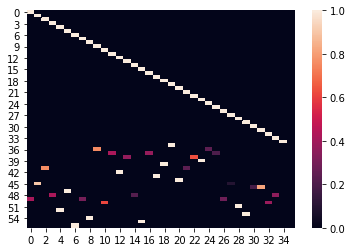

In [42]:
import seaborn as sns

sns.heatmap(nodes_to_leaves_probs.cpu().numpy())

In [43]:
adjmc = []
for x in adjm:
    a = x.shape[0]
    b = x.shape[1]
    temp = np.zeros((a + 1, b + 1))
    temp[:a, :b] = np.asarray(x)
    temp[a, b] = 1
    adjmc.append(temp)

## Dataset construction

### Debug Version -- Using labelled examples

In [44]:
labelled_data = combined[~where_query]

In [45]:
a_labels = label_to_id[expanded_labels[~where_query.values]].values
# a_labels[np.isnan(a_labels)] = -1
a_labels[np.isnan(a_labels)] = len(final_labels) - 1

dataset = AnnDatasetFromAnnData(labelled_data, batch_label="batch")
dataset.cell_types = label_to_id.index.values
dataset.labels = a_labels
dataset.n_labels = len(dataset.cell_types)
n_leaves_labels = len(final_labels)
dataset.filter_genes_by_count(per_batch=True)
dataset.subsample_genes(new_n_genes=3000)
dataset.labels = a_labels
dataset.n_labels = len(dataset.cell_types)

[2020-06-25 19:18:19,063] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-25 19:18:19,065] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


/data/yosef2/users/pierreboyeau/miniconda3/envs/scanvi/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:447: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/data/yosef2/users/pierreboyeau/miniconda3/envs/scanvi/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/data/yosef2/users/pierreboyeau/miniconda3/envs/scanvi/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:515: RuntimeWarning: Degrees of freedom <= 0 for slice
  return N.ndarray.var(self, axis, dtype, out, ddof, keepdims=True)._collapse(axis)
/data/yosef2/users/pierreboyeau/miniconda3/envs/scanvi/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/data/yosef2/users/pierreboyeau/miniconda3/envs/scanvi/lib/pyt

[2020-06-25 19:18:20,155] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-25 19:18:20,298] INFO - scvi.dataset.dataset | Downsampled from 20414 to 20414 cells
[2020-06-25 19:18:20,478] INFO - scvi.dataset.dataset | Downsampling from 21301 to 19881 genes
[2020-06-25 19:18:21,705] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-25 19:18:21,851] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-06-25 19:18:22,942] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-25 19:18:23,088] INFO - scvi.dataset.dataset | Downsampled from 20414 to 20414 cells
[2020-06-25 19:18:23,089] INFO - scvi.dataset.dataset | extracting highly variable genes


/data/yosef2/users/pierreboyeau/miniconda3/envs/scanvi/lib/python3.7/site-packages/anndata-0.7.3-py3.7.egg/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[2020-06-25 19:18:42,153] INFO - scvi.dataset.dataset | Downsampling from 19881 to 3000 genes
[2020-06-25 19:18:42,552] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-25 19:18:42,574] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-06-25 19:18:42,744] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-25 19:18:42,762] INFO - scvi.dataset.dataset | Downsampled from 20414 to 20414 cells


In [46]:
indices_labelled = None
indices_unlabelled = None

In [47]:
import torch.distributions as db

# need final label estimates
leaf_labels_ids = db.Categorical(nodes_to_leaves_probs[a_labels]).sample().cpu().numpy()

# leaf_labels_ids = label_to_id[leaf_labels[~where_query.values]].values
# leaf_labels_ids[np.isnan(leaf_labels_ids)] = -1

In [48]:
leaf_labels_ids

array([19, 34, 23, ...,  4,  4, 34])

### Prod version -- Using all data

In [ ]:
a_labels = label_to_id[expanded_labels].values
# a_labels[np.isnan(a_labels)] = -1
a_labels[np.isnan(a_labels)] = len(final_labels) - 1

dataset = AnnDatasetFromAnnData(combined, batch_label="batch")
dataset.cell_types = label_to_id.index.values
dataset.labels = a_labels
dataset.n_labels = len(dataset.cell_types)
n_leaves_labels = len(final_labels)
dataset.filter_genes_by_count(per_batch=True)
dataset.subsample_genes(new_n_genes=500)
dataset.labels = a_labels
dataset.n_labels = len(dataset.cell_types)

indices_labelled = np.where(~where_query.values)[0]
indices_unlabelled = np.where(where_query.values)[0]

print("indices_labelled: ", np.unique(dataset.labels[indices_labelled]))
print("indices_unlabelled: ", np.unique(dataset.labels[indices_unlabelled]))

In [ ]:
leaf_labels

In [ ]:
# need final label estimates
# leaves_estimates = db.Categorical(nodes_to_leaves_probs[a_labels]).sample().cpu().numpy()
leaf_labels_ids = label_to_id[leaf_labels].values
leaf_labels_ids[np.isnan(leaf_labels_ids)] = -1

### Model training

In [49]:
indices_labelled
indices_unlabelled

In [50]:
scanvi = SCANVI(
    dataset.nb_genes,
    dataset.n_batches,
    n_leaves_labels,
    n_layers=2,
    n_latent=30,
    symmetric_kl=True,
    use_ontology=True,
    ontology=adjmc,
)
scanvi.cuda()

trainer_scanvi = SemiSupervisedTrainer(
    scanvi,
    dataset,
    n_labels_final=n_leaves_labels,
    labels_of_use=leaf_labels_ids,
    n_epochs_classifier=100,
    lr_classification=5e-3,
    seed=1,
    n_epochs_kl_warmup=1,
    nodes_to_leaves_probs=nodes_to_leaves_probs,
    indices_labelled=indices_labelled,
    indices_unlabelled=indices_unlabelled,
)

trainer_scanvi.train(n_epochs=50)

labelled indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
unlabelled indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 52 53 54 55 56]
reconst_loss 324.63311767578125 5742328.5
reconst_loss 291.6951599121094 896194.625
reconst_loss 354.865478515625 1514080.75
reconst_loss 309.92266845703125 79831.1796875
reconst_loss 314.9972229003906 577210.125
reconst_loss 324.65966796875 20488.58984375
reconst_loss 359.3506774902344 20217.509765625
reconst_loss 276.2640075683594 23454.478515625
reconst_loss 291.666015625 15509.46484375
reconst_loss 277.92779541015625 11518.3125
reconst_loss 254.35922241210938 9186.564453125
reconst_loss 291.0028991699219 8737.7041015625
reconst_loss 253.63404846191406 32540.2734375
reconst_loss 199.04562377929688 11179.19238

reconst_loss 421.6336975097656 15138.9375
reconst_loss 248.86744689941406 22583.474609375
reconst_loss 243.78346252441406 276299.46875
reconst_loss 312.47625732421875 9788.2998046875
reconst_loss 293.6297302246094 7048.43310546875
reconst_loss 249.4656982421875 6306.27880859375
reconst_loss 348.2104797363281 8915.900390625
reconst_loss 254.68215942382812 9551.5791015625
reconst_loss 304.7866516113281 10214.7978515625
reconst_loss 200.32586669921875 19614.6640625
reconst_loss 401.0583801269531 8739.7431640625
reconst_loss 242.09866333007812 7750.1025390625
reconst_loss 317.5668029785156 18517.392578125
reconst_loss 323.2731018066406 21971.3671875
reconst_loss 342.786865234375 22972.34765625
reconst_loss 271.3385314941406 7881.5810546875
reconst_loss 271.9510192871094 11406.703125
reconst_loss 300.8924255371094 9850.4404296875
reconst_loss 293.824462890625 7590.73486328125
reconst_loss 313.49267578125 10889.4013671875
reconst_loss 198.93447875976562 92699.1953125
reconst_loss 248.5468444

reconst_loss 376.31439208984375 10405.7763671875
reconst_loss 317.9279479980469 6883.2822265625
reconst_loss 292.2990417480469 9550.2431640625
reconst_loss 331.9907531738281 9874.4384765625
reconst_loss 314.4288635253906 15844.9326171875
reconst_loss 236.89266967773438 8040.0263671875
reconst_loss 255.79949951171875 4680.4365234375
reconst_loss 242.5327606201172 3969.334716796875
reconst_loss 247.42538452148438 4273.4716796875
reconst_loss 240.3751983642578 5554.0654296875
reconst_loss 339.3471374511719 5705.8955078125
reconst_loss 318.4256591796875 11458.5498046875
reconst_loss 315.6318054199219 7249.22802734375
reconst_loss 209.48712158203125 5695.31689453125
reconst_loss 301.90057373046875 9952.076171875
reconst_loss 286.16766357421875 7010.3720703125
reconst_loss 257.7139892578125 8634.8935546875
reconst_loss 196.81716918945312 5677.5419921875
reconst_loss 207.10311889648438 8968.5908203125
reconst_loss 259.9201965332031 16518.923828125
reconst_loss 297.9488830566406 7972.22265625


reconst_loss 231.4909210205078 10825.953125
reconst_loss 175.0179443359375 4261.9248046875
reconst_loss 277.15264892578125 6809.537109375
reconst_loss 197.27114868164062 6520.67919921875
reconst_loss 307.7004089355469 4617.89208984375
reconst_loss 241.02117919921875 7950.8955078125
reconst_loss 213.87771606445312 7789.59130859375
reconst_loss 250.5729217529297 8923.3427734375
reconst_loss 268.3314208984375 4389.5244140625
reconst_loss 207.37640380859375 4663.50732421875
reconst_loss 291.4666442871094 10416.5703125
reconst_loss 228.9613037109375 5074.966796875
reconst_loss 238.662109375 8996.20703125
reconst_loss 237.591552734375 6672.54736328125
reconst_loss 260.0484619140625 9183.69140625
reconst_loss 144.5797119140625 4278.59130859375
reconst_loss 264.1165771484375 5058.80810546875
reconst_loss 227.5455780029297 4900.11767578125
reconst_loss 298.9716796875 5075.24365234375
reconst_loss 245.04608154296875 6240.8359375
reconst_loss 200.2928924560547 5112.314453125
reconst_loss 228.7454

reconst_loss 225.85336303710938 7104.25146484375
reconst_loss 189.51144409179688 3462.616455078125
reconst_loss 233.5845489501953 7513.08837890625
reconst_loss 186.320068359375 4745.45166015625
reconst_loss 219.37571716308594 9744.5986328125
reconst_loss 242.7128143310547 3106.385009765625
reconst_loss 237.17543029785156 6238.47265625
reconst_loss 181.971923828125 8840.82421875
reconst_loss 237.12332153320312 9257.693359375
reconst_loss 194.37753295898438 8190.103515625
reconst_loss 297.0623779296875 4762.1845703125
reconst_loss 221.76651000976562 4679.8310546875
reconst_loss 214.62913513183594 13879.80859375
reconst_loss 143.5462646484375 7086.953125
reconst_loss 214.23550415039062 9606.173828125
reconst_loss 215.23667907714844 5537.62060546875
reconst_loss 277.3963623046875 6205.4697265625
reconst_loss 267.0957946777344 6094.97021484375
reconst_loss 240.19952392578125 7380.60107421875
reconst_loss 172.32315063476562 6484.6435546875
reconst_loss 222.4017791748047 12331.33984375
recons

reconst_loss 142.2091064453125 9866.3212890625
reconst_loss 187.63815307617188 6437.48193359375
reconst_loss 185.8365478515625 3501.903564453125
reconst_loss 143.3122100830078 4432.970703125
reconst_loss 211.43112182617188 4749.67138671875
reconst_loss 222.02456665039062 2886.59228515625
reconst_loss 240.08651733398438 5234.9033203125
reconst_loss 201.19815063476562 4689.294921875
reconst_loss 173.57748413085938 4027.498779296875
reconst_loss 218.63624572753906 4953.29052734375
reconst_loss 187.54730224609375 7472.03564453125
reconst_loss 223.03807067871094 3875.774169921875
reconst_loss 162.4071502685547 5670.60498046875
reconst_loss 192.0565185546875 3904.6826171875
reconst_loss 217.59571838378906 8111.13232421875
reconst_loss 197.59335327148438 7367.67236328125
reconst_loss 264.3565979003906 4748.05126953125
reconst_loss 226.45201110839844 6154.10986328125
reconst_loss 207.51577758789062 6247.48095703125
reconst_loss 214.18336486816406 6108.37060546875
reconst_loss 198.6714172363281

reconst_loss 163.27944946289062 5861.90087890625
reconst_loss 180.46469116210938 3786.479736328125
reconst_loss 210.7393341064453 4570.15771484375
reconst_loss 185.90509033203125 5457.49267578125
reconst_loss 202.6552734375 4739.29931640625
reconst_loss 187.6518096923828 5723.79541015625
reconst_loss 204.6175079345703 5660.703125
reconst_loss 242.268310546875 6120.6923828125
reconst_loss 191.16156005859375 5818.95068359375
reconst_loss 190.0753173828125 3746.20068359375
reconst_loss 206.2855224609375 4084.572021484375
reconst_loss 154.00845336914062 6564.5322265625
reconst_loss 197.55755615234375 5700.69775390625
reconst_loss 135.71929931640625 9776.8330078125
reconst_loss 259.00518798828125 3707.71533203125
reconst_loss 238.59832763671875 5317.3408203125
reconst_loss 163.33038330078125 3399.36767578125
reconst_loss 186.49237060546875 3261.481201171875
reconst_loss 176.21640014648438 6212.85400390625
reconst_loss 162.51902770996094 4988.8974609375
reconst_loss 201.72378540039062 3491.1

reconst_loss 165.8861083984375 3268.43212890625
reconst_loss 220.86326599121094 4689.85888671875
reconst_loss 195.68792724609375 3786.692138671875
reconst_loss 187.26666259765625 2190.7744140625
reconst_loss 149.56468200683594 4371.46630859375
reconst_loss 172.85548400878906 4027.46435546875
reconst_loss 172.6039581298828 3165.5205078125
reconst_loss 188.3782196044922 5974.36474609375
reconst_loss 142.35865783691406 4685.18310546875
reconst_loss 196.06683349609375 13833.71484375
reconst_loss 190.44728088378906 5409.04052734375
reconst_loss 87.97628784179688 5651.69384765625
reconst_loss 150.1587677001953 4553.79345703125
reconst_loss 167.331787109375 3546.742919921875
reconst_loss 207.3654327392578 3892.159912109375
reconst_loss 187.81298828125 7026.85009765625
reconst_loss 205.44537353515625 4158.2216796875
reconst_loss 101.84095764160156 4069.841796875
reconst_loss 190.69509887695312 3533.1728515625
reconst_loss 163.9105987548828 5959.06591796875
reconst_loss 176.82858276367188 4207.

reconst_loss 207.83651733398438 9561.921875
reconst_loss 122.32540893554688 2822.649658203125
reconst_loss 146.88970947265625 4448.20361328125
reconst_loss 216.2750701904297 3398.443115234375
reconst_loss 213.32546997070312 4217.6435546875
reconst_loss 189.32177734375 6051.0087890625
reconst_loss 154.76126098632812 4339.0830078125
reconst_loss 176.326171875 4981.1181640625
reconst_loss 233.9749755859375 4566.89013671875
reconst_loss 195.6532440185547 5576.529296875
reconst_loss 215.25225830078125 4532.89111328125
reconst_loss 208.866455078125 16421.53125
reconst_loss 148.92494201660156 3975.247802734375
reconst_loss 169.85659790039062 4449.65087890625
reconst_loss 186.24725341796875 4675.47021484375
reconst_loss 185.87335205078125 7193.564453125
reconst_loss 151.2586669921875 7047.1708984375
reconst_loss 216.92791748046875 4140.50732421875
reconst_loss 193.2921142578125 6164.87158203125
reconst_loss 152.7414093017578 7250.87255859375
reconst_loss 203.60841369628906 2984.42236328125
rec

reconst_loss 187.56263732910156 5988.34375
reconst_loss 208.68719482421875 6975.83935546875
reconst_loss 169.5804443359375 6373.18017578125
reconst_loss 138.50888061523438 4905.8662109375
reconst_loss 145.2397003173828 4778.8486328125
reconst_loss 186.91566467285156 8213.7353515625
reconst_loss 186.27984619140625 4466.12255859375
reconst_loss 204.02487182617188 3799.324951171875
reconst_loss 203.22415161132812 4360.99462890625
reconst_loss 235.71205139160156 4047.760498046875
reconst_loss 148.96847534179688 4043.923583984375
reconst_loss 117.98260498046875 3894.997314453125
reconst_loss 142.66525268554688 5760.01171875
reconst_loss 150.62783813476562 3924.3505859375
reconst_loss 180.0644989013672 6886.17822265625
reconst_loss 211.92822265625 4609.72265625
reconst_loss 158.13876342773438 4824.85888671875
reconst_loss 128.4725799560547 6052.74560546875
reconst_loss 220.5688934326172 5905.41064453125
reconst_loss 185.6962890625 2745.2724609375
reconst_loss 100.92224884033203 5957.71777343

reconst_loss 143.52822875976562 2881.602294921875
reconst_loss 153.79405212402344 4983.43994140625
reconst_loss 141.68748474121094 4606.7294921875
reconst_loss 203.38580322265625 2813.3515625
reconst_loss 140.99703979492188 3386.431640625
reconst_loss 172.80014038085938 3823.316650390625
reconst_loss 165.81295776367188 5583.869140625
reconst_loss 152.49388122558594 4642.32421875
reconst_loss 120.55003356933594 4583.58349609375
reconst_loss 174.17453002929688 6524.517578125
reconst_loss 150.656494140625 5372.29248046875
reconst_loss 195.89199829101562 4405.2841796875
reconst_loss 171.17298889160156 4662.15869140625
reconst_loss 203.64730834960938 6983.20947265625
reconst_loss 181.39739990234375 4638.9736328125
reconst_loss 302.1746520996094 4626.0615234375
Epoch:  10
reconst_loss 169.24436950683594 5312.423828125
reconst_loss 189.3833465576172 3883.230712890625
reconst_loss 169.52098083496094 3015.462158203125
reconst_loss 196.77215576171875 3953.072021484375
reconst_loss 169.3677368164

reconst_loss 161.1645965576172 5759.12451171875
reconst_loss 187.8076171875 4933.60693359375
reconst_loss 195.81842041015625 4352.2099609375
Epoch:  11
reconst_loss 153.30706787109375 5041.125
reconst_loss 169.10345458984375 6212.28125
reconst_loss 187.20761108398438 3661.5517578125
reconst_loss 146.44496154785156 3479.59912109375
reconst_loss 160.10972595214844 5132.34912109375
reconst_loss 235.48521423339844 4249.04638671875
reconst_loss 191.65469360351562 4336.853515625
reconst_loss 147.0655059814453 4790.8017578125
reconst_loss 146.37057495117188 6007.01220703125
reconst_loss 157.09103393554688 7535.35009765625
reconst_loss 184.79397583007812 5739.359375
reconst_loss 182.78953552246094 2958.584716796875
reconst_loss 161.99436950683594 3356.015380859375
reconst_loss 168.53167724609375 5662.14013671875
reconst_loss 197.87216186523438 6863.7119140625
reconst_loss 115.1091079711914 4426.68701171875
reconst_loss 171.77593994140625 4457.970703125
reconst_loss 164.4686279296875 3947.66943

reconst_loss 192.74122619628906 6100.66796875
reconst_loss 121.2770767211914 4314.94970703125
reconst_loss 164.1960906982422 3883.309326171875
reconst_loss 153.21145629882812 4718.314453125
reconst_loss 195.91697692871094 4604.591796875
reconst_loss 171.79246520996094 3956.39306640625
reconst_loss 181.04339599609375 4163.76708984375
reconst_loss 182.9337158203125 3784.34375
reconst_loss 188.35035705566406 3499.0
reconst_loss 185.19171142578125 3913.84228515625
reconst_loss 167.2508544921875 8992.51171875
reconst_loss 190.29278564453125 5748.67041015625
reconst_loss 167.49600219726562 6054.64697265625
reconst_loss 180.17169189453125 4129.896484375
reconst_loss 174.09327697753906 4327.61962890625
reconst_loss 211.84339904785156 3649.69482421875
reconst_loss 128.6580047607422 3758.880615234375
reconst_loss 179.8153533935547 4310.6201171875
reconst_loss 193.70437622070312 4839.8740234375
reconst_loss 182.125 4660.71142578125
reconst_loss 120.60397338867188 3545.552490234375
reconst_loss 16

reconst_loss 135.46054077148438 4978.0830078125
reconst_loss 199.81544494628906 3808.298583984375
reconst_loss 206.39083862304688 3825.4287109375
reconst_loss 179.43675231933594 3015.72265625
reconst_loss 192.20962524414062 3301.053466796875
reconst_loss 154.892578125 3820.794921875
reconst_loss 236.66685485839844 7271.86376953125
reconst_loss 220.61810302734375 3775.818603515625
reconst_loss 140.67892456054688 2301.51025390625
reconst_loss 166.59388732910156 3904.81884765625
reconst_loss 147.92572021484375 4353.865234375
reconst_loss 163.1919708251953 4754.10400390625
reconst_loss 177.37655639648438 3000.111328125
reconst_loss 169.1296844482422 5543.890625
reconst_loss 166.7857208251953 4060.80810546875
reconst_loss 153.4123992919922 4228.52978515625
reconst_loss 178.79176330566406 6437.14501953125
reconst_loss 153.65817260742188 4396.49169921875
reconst_loss 176.86769104003906 7179.55224609375
reconst_loss 169.33518981933594 3219.0654296875
reconst_loss 186.3971710205078 2728.2534179

reconst_loss 195.70846557617188 4114.58447265625
reconst_loss 159.21499633789062 4627.54931640625
reconst_loss 147.78567504882812 6842.91552734375
reconst_loss 190.69009399414062 3701.99462890625
reconst_loss 150.59548950195312 4807.98876953125
reconst_loss 66.62586975097656 4977.61328125
reconst_loss 183.60984802246094 4042.62548828125
reconst_loss 139.54808044433594 3874.222412109375
reconst_loss 135.81082153320312 4108.90771484375
reconst_loss 154.3058319091797 3972.810302734375
reconst_loss 175.3467559814453 4806.40478515625
reconst_loss 114.36241149902344 2839.119384765625
reconst_loss 157.31150817871094 4200.0908203125
reconst_loss 150.70372009277344 3870.86669921875
reconst_loss 170.33160400390625 4415.677734375
reconst_loss 155.38165283203125 3320.359375
reconst_loss 165.43972778320312 3938.171630859375
reconst_loss 157.07662963867188 4874.54541015625
reconst_loss 154.31094360351562 6217.3623046875
reconst_loss 148.94570922851562 4598.2412109375
reconst_loss 140.4997100830078 2

reconst_loss 168.44174194335938 4432.501953125
reconst_loss 119.90934753417969 3961.4833984375
reconst_loss 172.59967041015625 4233.6923828125
reconst_loss 133.33457946777344 4554.75244140625
reconst_loss 183.49566650390625 4474.703125
reconst_loss 143.814453125 4978.0712890625
reconst_loss 151.28152465820312 3387.25537109375
reconst_loss 168.18722534179688 3489.937255859375
reconst_loss 177.18756103515625 4237.5654296875
reconst_loss 131.97982788085938 4337.69970703125
reconst_loss 200.16343688964844 5788.48486328125
reconst_loss 180.43441772460938 3660.859375
reconst_loss 174.0124969482422 2436.27197265625
reconst_loss 212.30856323242188 3968.625732421875
reconst_loss 162.6293487548828 5030.107421875
reconst_loss 176.88543701171875 6677.38037109375
reconst_loss 187.56787109375 4268.19580078125
reconst_loss 170.51812744140625 2248.682861328125
reconst_loss 162.2862548828125 3863.627685546875
reconst_loss 169.6204833984375 4182.2783203125
reconst_loss 161.51071166992188 4760.5205078125

reconst_loss 125.3988037109375 3277.95263671875
reconst_loss 194.2312774658203 3829.79736328125
reconst_loss 172.46107482910156 6229.236328125
reconst_loss 149.9303741455078 4345.6689453125
reconst_loss 74.53512573242188 3602.8642578125
reconst_loss 174.27059936523438 6375.8388671875
reconst_loss 212.94529724121094 3832.755859375
reconst_loss 152.01039123535156 3295.58349609375
reconst_loss 146.0249786376953 4342.5146484375
reconst_loss 212.9413604736328 4798.75634765625
reconst_loss 175.33489990234375 2493.732177734375
reconst_loss 164.11068725585938 4284.33056640625
reconst_loss 181.74002075195312 3355.846435546875
reconst_loss 150.61236572265625 6740.65234375
reconst_loss 178.17037963867188 3805.670166015625
reconst_loss 126.21479797363281 3599.56396484375
reconst_loss 173.52273559570312 4686.13916015625
reconst_loss 164.58834838867188 3186.728515625
reconst_loss 173.39547729492188 3741.697021484375
reconst_loss 145.69564819335938 2824.00634765625
reconst_loss 158.3386688232422 4122

reconst_loss 150.26773071289062 3167.48681640625
reconst_loss 117.09031677246094 7040.65234375
reconst_loss 153.5413818359375 3357.908935546875
reconst_loss 148.01373291015625 6203.2861328125
reconst_loss 145.80758666992188 4269.66845703125
reconst_loss 164.20216369628906 6804.96142578125
reconst_loss 130.59197998046875 4369.98779296875
reconst_loss 141.94822692871094 3811.337158203125
reconst_loss 133.85873413085938 3896.62744140625
reconst_loss 158.61868286132812 2691.996826171875
reconst_loss 171.63084411621094 3673.513671875
reconst_loss 142.7388916015625 3054.371826171875
reconst_loss 173.72116088867188 3157.908935546875
reconst_loss 176.40585327148438 3440.73974609375
reconst_loss 160.0914306640625 3786.75537109375
reconst_loss 150.42645263671875 3809.9541015625
reconst_loss 130.00833129882812 4377.86572265625
reconst_loss 139.85679626464844 4694.0771484375
reconst_loss 168.57896423339844 4472.8740234375
reconst_loss 150.30270385742188 4385.107421875
reconst_loss 186.327621459960

reconst_loss 165.17807006835938 4131.8779296875
reconst_loss 115.41804504394531 4751.90771484375
reconst_loss 167.8073272705078 4824.82470703125
reconst_loss 163.68011474609375 4221.01806640625
reconst_loss 172.47198486328125 4136.45849609375
reconst_loss 169.33668518066406 4388.7646484375
reconst_loss 165.54281616210938 4917.7734375
reconst_loss 169.45362854003906 4488.26025390625
reconst_loss 171.20777893066406 6708.0244140625
reconst_loss 143.9781036376953 5235.8740234375
reconst_loss 167.62576293945312 3891.635009765625
reconst_loss 149.64263916015625 4381.021484375
reconst_loss 137.77838134765625 4221.6748046875
reconst_loss 159.27955627441406 4133.13916015625
reconst_loss 152.65188598632812 5880.87353515625
reconst_loss 139.3136749267578 4312.0556640625
reconst_loss 162.119384765625 3959.393310546875
reconst_loss 176.8287353515625 3772.496337890625
reconst_loss 189.46487426757812 2484.31640625
reconst_loss 121.97488403320312 3630.52685546875
reconst_loss 151.03369140625 4119.1181

reconst_loss 168.89573669433594 5789.921875
reconst_loss 142.24044799804688 2951.872802734375
reconst_loss 139.3023681640625 4536.32177734375
reconst_loss 139.47561645507812 4835.9716796875
reconst_loss 152.75038146972656 3154.344482421875
reconst_loss 161.35423278808594 3887.272705078125
reconst_loss 188.11770629882812 6750.98193359375
reconst_loss 153.0923614501953 5487.185546875
reconst_loss 196.41152954101562 3493.39892578125
reconst_loss 134.42767333984375 3208.697265625
reconst_loss 165.54934692382812 5559.380859375
reconst_loss 154.01199340820312 3849.437744140625
reconst_loss 130.6410675048828 4002.896728515625
reconst_loss 182.14065551757812 3212.259765625
reconst_loss 151.4158935546875 4442.22314453125
reconst_loss 178.69833374023438 3493.50927734375
reconst_loss 148.84902954101562 3529.35888671875
reconst_loss 171.66517639160156 4272.73583984375
reconst_loss 128.54580688476562 6084.7685546875
reconst_loss 168.0668487548828 4539.71533203125
reconst_loss 150.82928466796875 411

reconst_loss 135.88525390625 2933.22119140625
reconst_loss 189.86253356933594 3245.75537109375
reconst_loss 129.22500610351562 4315.21240234375
reconst_loss 151.07546997070312 4364.90625
reconst_loss 135.27593994140625 3964.534423828125
reconst_loss 115.97344970703125 3553.04443359375
reconst_loss 159.5244140625 3829.799072265625
reconst_loss 169.96441650390625 6281.91650390625
reconst_loss 187.38638305664062 3071.160888671875
reconst_loss 148.7162628173828 3762.227294921875
reconst_loss 147.81918334960938 4981.787109375
reconst_loss 134.94412231445312 4658.2041015625
reconst_loss 195.4421844482422 4795.138671875
reconst_loss 154.72552490234375 4514.98388671875
reconst_loss 157.15980529785156 5788.1396484375
reconst_loss 196.1923065185547 4263.0859375
reconst_loss 159.98243713378906 3348.7548828125
reconst_loss 174.96575927734375 6750.3125
reconst_loss 164.65310668945312 3911.41796875
reconst_loss 171.32723999023438 3573.806640625
reconst_loss 132.94729614257812 4682.912109375
reconst_

reconst_loss 161.7829132080078 3958.6064453125
reconst_loss 147.080810546875 5325.9794921875
reconst_loss 152.9540557861328 4866.23486328125
reconst_loss 129.90347290039062 5749.19189453125
reconst_loss 121.49166870117188 3035.359619140625
reconst_loss 155.98312377929688 5560.4453125
reconst_loss 150.23532104492188 5908.52880859375
reconst_loss 180.2711181640625 3750.044921875
reconst_loss 126.25320434570312 4606.6552734375
reconst_loss 162.9243621826172 5120.61572265625
reconst_loss 178.47109985351562 3994.7392578125
reconst_loss 160.41299438476562 5831.595703125
reconst_loss 130.69644165039062 3942.736572265625
reconst_loss 173.26080322265625 3921.4853515625
reconst_loss 146.75083923339844 3658.179443359375
reconst_loss 120.60000610351562 6913.94775390625
reconst_loss 196.46168518066406 2673.3828125
reconst_loss 191.7216033935547 3837.11083984375
reconst_loss 143.91323852539062 5275.5078125
reconst_loss 168.9990234375 4259.89013671875
reconst_loss 160.32745361328125 3435.08154296875


reconst_loss 117.98268127441406 5853.8017578125
reconst_loss 171.26675415039062 6424.98974609375
reconst_loss 143.9453887939453 5845.751953125
reconst_loss 155.66372680664062 3970.67431640625
reconst_loss 136.39141845703125 5411.74072265625
reconst_loss 158.5590057373047 3918.169189453125
reconst_loss 180.7703399658203 3919.6396484375
reconst_loss 176.33212280273438 6697.4111328125
reconst_loss 148.9949493408203 3682.5302734375
reconst_loss 167.29342651367188 5224.8271484375
reconst_loss 122.12843322753906 4332.4873046875
reconst_loss 160.91278076171875 3969.685791015625
reconst_loss 189.2880401611328 3478.212646484375
reconst_loss 167.25418090820312 4133.82080078125
reconst_loss 155.90234375 3521.8857421875
reconst_loss 138.64996337890625 3150.565673828125
reconst_loss 108.86328125 4621.7978515625
reconst_loss 150.1088409423828 3418.3095703125
reconst_loss 148.63629150390625 5281.716796875
reconst_loss 112.73558044433594 3104.1396484375
reconst_loss 173.47164916992188 3097.59448242187

reconst_loss 157.92816162109375 2067.961669921875
reconst_loss 187.16860961914062 4238.4326171875
reconst_loss 136.27088928222656 3967.96240234375
reconst_loss 177.23910522460938 3908.8994140625
reconst_loss 121.29662322998047 5530.7412109375
reconst_loss 117.65289306640625 3567.26025390625
reconst_loss 151.52622985839844 3397.087646484375
reconst_loss 156.12713623046875 5526.70263671875
reconst_loss 143.88059997558594 4600.05908203125
Epoch:  24
reconst_loss 136.98028564453125 4785.75
reconst_loss 122.99392700195312 2739.25732421875
reconst_loss 177.7373046875 2142.67724609375
reconst_loss 133.82974243164062 4065.11669921875
reconst_loss 127.44349670410156 6103.4189453125
reconst_loss 136.91195678710938 4493.95654296875
reconst_loss 185.08721923828125 2800.912109375
reconst_loss 152.05905151367188 3579.39697265625
reconst_loss 137.4744415283203 4353.26171875
reconst_loss 172.7728271484375 5664.57861328125
reconst_loss 168.56802368164062 3894.055908203125
reconst_loss 113.1090011596679

reconst_loss 139.19346618652344 6560.6806640625
reconst_loss 141.0507049560547 3834.39404296875
reconst_loss 184.37808227539062 3328.16357421875
reconst_loss 161.6772918701172 2777.93994140625
reconst_loss 112.8659896850586 4447.79296875
reconst_loss 166.3887481689453 4704.2666015625
reconst_loss 155.4638214111328 3369.65478515625
reconst_loss 186.38491821289062 3967.38134765625
reconst_loss 136.5196990966797 4152.248046875
reconst_loss 142.02638244628906 4735.55615234375
reconst_loss 159.17823791503906 3659.882568359375
reconst_loss 152.1680908203125 3232.455810546875
reconst_loss 118.66729736328125 4015.67041015625
reconst_loss 125.89777374267578 4077.498291015625
reconst_loss 182.2082977294922 4619.8955078125
reconst_loss 145.42813110351562 6668.60986328125
reconst_loss 113.34675598144531 3677.443359375
reconst_loss 152.7303466796875 4380.685546875
reconst_loss 171.36883544921875 4127.89501953125
reconst_loss 168.67933654785156 4107.38427734375
reconst_loss 134.0413055419922 4407.29

reconst_loss 154.18077087402344 6343.71728515625
reconst_loss 152.82423400878906 4319.1630859375
reconst_loss 137.323974609375 4191.7060546875
reconst_loss 165.6835479736328 5994.150390625
reconst_loss 153.78114318847656 3579.44287109375
reconst_loss 140.67819213867188 4202.38037109375
reconst_loss 114.53425598144531 2483.636962890625
reconst_loss 157.32733154296875 3851.733642578125
reconst_loss 183.78329467773438 4734.623046875
reconst_loss 163.4612274169922 4002.671630859375
reconst_loss 154.97689819335938 6603.65234375
reconst_loss 173.24636840820312 5752.2607421875
reconst_loss 107.37921142578125 4838.95947265625
reconst_loss 141.22723388671875 6149.626953125
reconst_loss 203.1160125732422 3409.2587890625
reconst_loss 164.39999389648438 4752.97998046875
reconst_loss 169.9655303955078 2653.931640625
reconst_loss 167.547607421875 3093.27978515625
reconst_loss 168.6531982421875 4609.423828125
reconst_loss 136.44285583496094 4642.8857421875
reconst_loss 141.2391357421875 3189.32714843

reconst_loss 125.69129180908203 3615.69580078125
reconst_loss 121.04612731933594 2275.863525390625
reconst_loss 171.86318969726562 4244.6767578125
reconst_loss 124.61271667480469 3850.098388671875
reconst_loss 130.79898071289062 3395.302734375
reconst_loss 142.96075439453125 2707.787353515625
reconst_loss 171.22784423828125 4212.19384765625
reconst_loss 112.06560516357422 4105.5205078125
reconst_loss 142.9866943359375 4478.94140625
reconst_loss 148.8601531982422 3602.526611328125
reconst_loss 119.41607666015625 4661.88134765625
reconst_loss 144.8626251220703 4072.902099609375
reconst_loss 155.92384338378906 4193.56201171875
reconst_loss 190.86892700195312 9035.2734375
reconst_loss 164.87403869628906 3993.41162109375
reconst_loss 144.03750610351562 3989.096923828125
reconst_loss 136.1291046142578 3345.88525390625
reconst_loss 150.09719848632812 2958.467529296875
reconst_loss 135.71475219726562 4205.1884765625
reconst_loss 200.72222900390625 5525.8857421875
reconst_loss 152.2106170654297

reconst_loss 149.65484619140625 17286.466796875
reconst_loss 135.80169677734375 6120.61083984375
reconst_loss 123.75100708007812 6172.72998046875
reconst_loss 117.81594848632812 3681.427490234375
reconst_loss 136.68182373046875 4121.89111328125
reconst_loss 183.86215209960938 4437.6689453125
reconst_loss 181.875244140625 3773.36669921875
reconst_loss 119.10575866699219 7086.32958984375
reconst_loss 148.29786682128906 3994.88330078125
reconst_loss 183.108642578125 9301.646484375
reconst_loss 192.68943786621094 6967.240234375
reconst_loss 160.1890106201172 2963.556884765625
reconst_loss 145.27981567382812 5526.85498046875
reconst_loss 119.93658447265625 9063.1572265625
reconst_loss 138.65521240234375 2531.5400390625
reconst_loss 148.34689331054688 6891.9296875
reconst_loss 144.62503051757812 5185.54833984375
reconst_loss 173.22901916503906 3128.44873046875
reconst_loss 153.89291381835938 7241.85107421875
reconst_loss 135.50311279296875 4254.0908203125
reconst_loss 134.25704956054688 5325

reconst_loss 151.9253692626953 6825.00634765625
reconst_loss 135.63381958007812 4697.76171875
reconst_loss 109.42046356201172 5328.35009765625
reconst_loss 144.35743713378906 3187.6865234375
reconst_loss 144.6121826171875 3220.84130859375
reconst_loss 128.48281860351562 4069.75537109375
reconst_loss 135.82681274414062 4110.24169921875
reconst_loss 138.574462890625 5355.35302734375
reconst_loss 157.68240356445312 4178.60693359375
reconst_loss 131.58042907714844 3272.75390625
reconst_loss 137.0050048828125 6525.96240234375
reconst_loss 135.81857299804688 3818.70654296875
reconst_loss 155.19464111328125 3484.9970703125
reconst_loss 154.84231567382812 3177.64501953125
reconst_loss 143.7996826171875 3267.700927734375
reconst_loss 115.97737121582031 3590.572509765625
reconst_loss 129.84010314941406 3596.90625
reconst_loss 148.50437927246094 2330.789306640625
reconst_loss 187.23440551757812 3676.665771484375
reconst_loss 124.21717834472656 3029.4169921875
reconst_loss 164.21629333496094 5573.

reconst_loss 112.32858276367188 3705.951171875
reconst_loss 129.20086669921875 4433.5322265625
reconst_loss 173.07113647460938 4338.58447265625
reconst_loss 160.79490661621094 3276.572509765625
reconst_loss 155.88316345214844 5851.908203125
reconst_loss 159.66001892089844 4891.03564453125
reconst_loss 171.3662567138672 3986.716796875
reconst_loss 151.572265625 4424.056640625
reconst_loss 161.87081909179688 8476.078125
reconst_loss 144.01400756835938 4156.8046875
reconst_loss 138.2846221923828 2591.788330078125
reconst_loss 117.03143310546875 3010.196044921875
reconst_loss 122.42117309570312 4603.98779296875
reconst_loss 163.73382568359375 3695.912109375
reconst_loss 130.2270965576172 4698.46142578125
reconst_loss 111.97430419921875 4271.04541015625
reconst_loss 155.5636749267578 3325.268310546875
reconst_loss 141.25955200195312 3538.26708984375
reconst_loss 164.4857940673828 6471.587890625
reconst_loss 163.4356689453125 5428.24267578125
reconst_loss 138.95013427734375 3383.06787109375


reconst_loss 179.37547302246094 5435.52099609375
reconst_loss 130.79083251953125 4043.68896484375
reconst_loss 162.20851135253906 5622.60205078125
reconst_loss 167.4954376220703 5937.37060546875
reconst_loss 133.3326873779297 5848.935546875
reconst_loss 156.79306030273438 4560.46044921875
reconst_loss 179.70045471191406 3608.257568359375
reconst_loss 160.24301147460938 4292.17041015625
reconst_loss 165.62057495117188 4638.88134765625
reconst_loss 147.2663116455078 12527.6474609375
reconst_loss 111.16360473632812 3868.57177734375
reconst_loss 143.9741668701172 3372.626708984375
reconst_loss 106.2964859008789 2741.2763671875
reconst_loss 147.9035186767578 3904.001220703125
reconst_loss 103.10591125488281 4664.7138671875
reconst_loss 156.65472412109375 3636.12548828125
reconst_loss 181.22222900390625 4035.56787109375
reconst_loss 122.33722686767578 4251.49609375
reconst_loss 115.64173889160156 5715.82080078125
reconst_loss 174.02206420898438 3677.9775390625
reconst_loss 119.29620361328125

reconst_loss 165.13265991210938 4024.2666015625
reconst_loss 129.65150451660156 3829.756103515625
reconst_loss 172.58087158203125 3292.862060546875
reconst_loss 140.00794982910156 4111.08349609375
reconst_loss 144.7982940673828 3317.172119140625
reconst_loss 228.65704345703125 4444.33984375
reconst_loss 151.49485778808594 3406.667724609375
reconst_loss 138.71438598632812 3728.539794921875
reconst_loss 145.3774871826172 4334.58349609375
reconst_loss 130.43862915039062 3330.160400390625
reconst_loss 110.72222900390625 3212.72265625
reconst_loss 118.21316528320312 4294.76123046875
reconst_loss 168.4884490966797 4060.050537109375
reconst_loss 132.0905303955078 4398.96533203125
reconst_loss 167.35305786132812 4389.2783203125
reconst_loss 130.87655639648438 2578.0458984375
reconst_loss 144.8497772216797 2680.856201171875
reconst_loss 105.58731842041016 5452.90234375
reconst_loss 182.35888671875 4774.70849609375
reconst_loss 144.45114135742188 3777.2666015625
reconst_loss 164.9687957763672 24

reconst_loss 123.36433410644531 4619.5517578125
reconst_loss 171.2352294921875 3198.829833984375
reconst_loss 132.88026428222656 2717.217529296875
reconst_loss 166.00668334960938 3314.26708984375
reconst_loss 122.91524505615234 3254.40478515625
reconst_loss 124.90061950683594 4229.634765625
reconst_loss 135.56275939941406 3991.586669921875
reconst_loss 162.0410919189453 3814.9423828125
reconst_loss 163.81846618652344 4032.739990234375
reconst_loss 151.76986694335938 2375.335205078125
reconst_loss 133.5850830078125 5736.0859375
reconst_loss 143.56739807128906 4045.560791015625
reconst_loss 140.1202850341797 4798.1240234375
reconst_loss 173.02880859375 6485.1748046875
reconst_loss 124.5064468383789 9087.615234375
reconst_loss 110.0722885131836 5933.9306640625
reconst_loss 137.14878845214844 5091.90625
reconst_loss 167.85595703125 4675.97314453125
reconst_loss 108.20016479492188 3728.6484375
reconst_loss 168.04263305664062 5287.6708984375
reconst_loss 142.52474975585938 4090.5458984375
re

reconst_loss 145.58050537109375 3346.64892578125
reconst_loss 169.544189453125 3302.341064453125
reconst_loss 163.8352813720703 3803.877197265625
reconst_loss 147.83233642578125 2815.03173828125
reconst_loss 129.21815490722656 3276.473388671875
reconst_loss 182.22120666503906 6020.3173828125
reconst_loss 156.16696166992188 3196.152099609375
reconst_loss 119.36337280273438 3764.359130859375
reconst_loss 166.44981384277344 6290.66064453125
reconst_loss 140.31826782226562 6158.791015625
reconst_loss 161.7226104736328 3391.18310546875
reconst_loss 137.0764923095703 3073.910400390625
reconst_loss 156.55227661132812 5202.4306640625
reconst_loss 132.78228759765625 5187.953125
reconst_loss 133.7419891357422 3442.5673828125
reconst_loss 150.599853515625 2815.66650390625
reconst_loss 124.75668334960938 6700.54345703125
reconst_loss 136.4733428955078 3068.0234375
reconst_loss 167.13072204589844 4140.21533203125
reconst_loss 164.3992156982422 4016.80322265625
reconst_loss 153.18484497070312 4298.4

reconst_loss 154.8651123046875 2628.134521484375
reconst_loss 136.3424835205078 3938.5537109375
reconst_loss 135.9102783203125 5656.19384765625
reconst_loss 109.8309326171875 4008.44140625
reconst_loss 145.57720947265625 3229.73779296875
reconst_loss 139.31851196289062 2381.86279296875
reconst_loss 135.01901245117188 3055.037109375
reconst_loss 169.53408813476562 5370.552734375
reconst_loss 141.0772247314453 4169.27392578125
reconst_loss 151.0685577392578 3919.90625
reconst_loss 170.22030639648438 3728.122314453125
reconst_loss 87.31718444824219 4777.009765625
reconst_loss 163.8648223876953 5639.8662109375
reconst_loss 159.52114868164062 5075.79345703125
reconst_loss 174.42117309570312 4068.992919921875
reconst_loss 168.37905883789062 3591.302734375
reconst_loss 124.72454833984375 3701.171142578125
reconst_loss 107.68721771240234 6904.57275390625
reconst_loss 79.16329956054688 3139.70947265625
reconst_loss 107.43443298339844 3638.763427734375
reconst_loss 129.98721313476562 4130.430175

reconst_loss 130.70486450195312 4564.12158203125
reconst_loss 119.32914733886719 5648.78515625
reconst_loss 132.4061737060547 4733.7978515625
reconst_loss 122.1315689086914 3788.761962890625
reconst_loss 79.7150650024414 2298.16259765625
reconst_loss 153.94676208496094 3479.80029296875
reconst_loss 135.63473510742188 2806.389892578125
reconst_loss 137.79367065429688 3731.300048828125
reconst_loss 175.0734405517578 4436.3212890625
reconst_loss 89.84718322753906 3324.934326171875
reconst_loss 155.57330322265625 3224.804443359375
reconst_loss 148.2952880859375 5629.763671875
reconst_loss 154.27517700195312 4221.1005859375
reconst_loss 117.17860412597656 3731.970947265625
reconst_loss 165.03477478027344 5678.23681640625
reconst_loss 155.3314666748047 2927.431884765625
reconst_loss 158.1829376220703 4104.40234375
reconst_loss 146.3779296875 5231.92529296875
reconst_loss 167.84205627441406 3955.528564453125
reconst_loss 171.74668884277344 5579.97119140625
reconst_loss 171.9579315185547 4013.

reconst_loss 106.1097412109375 5306.646484375
reconst_loss 146.0569305419922 6021.03466796875
reconst_loss 128.06207275390625 5315.41845703125
reconst_loss 115.8883056640625 4002.1298828125
reconst_loss 92.53119659423828 4483.15380859375
reconst_loss 121.8448486328125 6799.61669921875
reconst_loss 178.619384765625 2941.150146484375
reconst_loss 96.09747314453125 4437.0009765625
reconst_loss 154.48046875 4735.7568359375
Epoch:  38
reconst_loss 163.03976440429688 5439.34326171875
reconst_loss 134.6895751953125 4062.00732421875
reconst_loss 130.4644775390625 2657.688232421875
reconst_loss 131.27320861816406 3221.20703125
reconst_loss 133.45799255371094 2402.59375
reconst_loss 183.45387268066406 3000.603759765625
reconst_loss 151.564453125 3212.146240234375
reconst_loss 176.52064514160156 4589.42138671875
reconst_loss 157.70205688476562 2064.688232421875
reconst_loss 148.05418395996094 5198.52197265625
reconst_loss 149.61648559570312 3380.966064453125
reconst_loss 133.57957458496094 4024.0

reconst_loss 116.82962036132812 6604.26123046875
reconst_loss 120.65238189697266 3842.696533203125
reconst_loss 138.20645141601562 5261.5498046875
reconst_loss 221.6970672607422 4716.70263671875
reconst_loss 158.55838012695312 3923.6552734375
reconst_loss 151.60577392578125 5560.85498046875
reconst_loss 133.88758850097656 3804.783935546875
reconst_loss 174.19078063964844 4275.16455078125
reconst_loss 132.62496948242188 5072.04248046875
reconst_loss 138.7985382080078 3391.4150390625
reconst_loss 68.99702453613281 2961.463623046875
reconst_loss 157.27114868164062 4180.05029296875
reconst_loss 148.57376098632812 2977.078369140625
reconst_loss 143.89901733398438 3988.105712890625
reconst_loss 138.66143798828125 4199.87939453125
reconst_loss 155.01873779296875 4752.99609375
reconst_loss 165.64852905273438 4107.22314453125
reconst_loss 164.69357299804688 4034.971435546875
reconst_loss 172.08706665039062 6545.82275390625
reconst_loss 150.87681579589844 4557.2021484375
reconst_loss 135.4791412

reconst_loss 154.37704467773438 5312.00341796875
reconst_loss 141.76177978515625 3710.9169921875
reconst_loss 115.59937286376953 3817.8642578125
reconst_loss 166.0232696533203 4145.9404296875
reconst_loss 164.0779571533203 5578.22314453125
reconst_loss 135.45721435546875 5385.2421875
reconst_loss 109.47445678710938 4271.244140625
reconst_loss 184.28695678710938 3376.067626953125
reconst_loss 117.50653076171875 3990.650634765625
reconst_loss 115.62995910644531 5696.8701171875
reconst_loss 128.55093383789062 4344.0341796875
reconst_loss 149.52584838867188 3681.0107421875
reconst_loss 135.55313110351562 2278.04833984375
reconst_loss 145.1192626953125 3736.77197265625
reconst_loss 147.46861267089844 4231.7734375
reconst_loss 120.21360778808594 4509.6630859375
reconst_loss 129.94232177734375 5953.484375
reconst_loss 160.92408752441406 3671.507080078125
reconst_loss 113.54804992675781 4348.7939453125
reconst_loss 139.4852294921875 3727.794189453125
reconst_loss 154.097412109375 3182.05541992

reconst_loss 123.47471618652344 3672.361572265625
reconst_loss 147.23382568359375 4560.63623046875
reconst_loss 139.85595703125 4240.6044921875
reconst_loss 118.57118225097656 2964.7509765625
reconst_loss 135.9231414794922 5193.1748046875
reconst_loss 161.90377807617188 5515.56640625
reconst_loss 129.53555297851562 2911.52783203125
reconst_loss 129.58935546875 3736.763916015625
reconst_loss 109.43756866455078 3885.28369140625
reconst_loss 148.26644897460938 3934.736572265625
reconst_loss 132.68675231933594 5934.0205078125
reconst_loss 120.12821197509766 4040.9462890625
reconst_loss 112.75707244873047 3595.98486328125
reconst_loss 143.506591796875 4522.0517578125
reconst_loss 162.057861328125 3156.9130859375
reconst_loss 168.17257690429688 3641.78662109375
reconst_loss 143.7355194091797 4619.45849609375
reconst_loss 110.4276123046875 4120.361328125
reconst_loss 127.88349914550781 3721.31103515625
reconst_loss 131.286865234375 2913.637939453125
reconst_loss 167.6455841064453 3383.4243164

reconst_loss 137.65536499023438 2267.63330078125
reconst_loss 115.97035217285156 6971.6142578125
reconst_loss 138.31668090820312 3633.149169921875
reconst_loss 138.53985595703125 4058.22705078125
reconst_loss 152.28964233398438 4475.91845703125
reconst_loss 144.84677124023438 4225.5390625
reconst_loss 163.61412048339844 3430.760498046875
reconst_loss 180.81015014648438 3872.033447265625
reconst_loss 154.0953369140625 4429.33447265625
reconst_loss 178.8948516845703 3829.227783203125
reconst_loss 127.87930297851562 5945.1591796875
reconst_loss 157.16322326660156 2858.01513671875
reconst_loss 132.75369262695312 3541.767578125
reconst_loss 115.66925048828125 3127.385498046875
reconst_loss 175.39865112304688 5374.60546875
reconst_loss 132.68524169921875 4192.9619140625
reconst_loss 133.78741455078125 4055.5693359375
reconst_loss 175.07376098632812 3589.226806640625
reconst_loss 173.75889587402344 4833.509765625
reconst_loss 149.80258178710938 4526.4404296875
reconst_loss 137.93063354492188 

reconst_loss 122.06970977783203 3436.234375
reconst_loss 171.1385040283203 2994.312255859375
reconst_loss 174.0288543701172 4265.7392578125
reconst_loss 139.6044921875 2903.80322265625
reconst_loss 119.18328094482422 3292.248046875
reconst_loss 155.11489868164062 2872.98193359375
reconst_loss 109.43794250488281 3932.472900390625
reconst_loss 146.63973999023438 3986.430419921875
reconst_loss 156.85601806640625 4165.1240234375
reconst_loss 152.33311462402344 5916.66552734375
reconst_loss 107.5837631225586 5732.90478515625
reconst_loss 175.05274963378906 3710.8583984375
reconst_loss 168.16412353515625 5576.84765625
reconst_loss 143.27352905273438 4114.43603515625
reconst_loss 147.57247924804688 3240.11328125
reconst_loss 136.27455139160156 4521.72265625
reconst_loss 135.38294982910156 4583.4052734375
reconst_loss 102.51787567138672 4685.7509765625
reconst_loss 155.62142944335938 4486.38720703125
reconst_loss 130.83619689941406 6401.15576171875
reconst_loss 162.98101806640625 3552.04882812

reconst_loss 129.35397338867188 3550.73193359375
reconst_loss 129.62466430664062 5151.970703125
reconst_loss 128.35073852539062 2982.267578125
reconst_loss 127.47633361816406 2699.905029296875
reconst_loss 188.94744873046875 2972.132080078125
reconst_loss 137.3673858642578 2791.68603515625
reconst_loss 153.9637451171875 3263.779052734375
reconst_loss 137.72108459472656 4054.218505859375
reconst_loss 156.3367156982422 2714.10986328125
reconst_loss 129.0811767578125 3837.624267578125
reconst_loss 111.52217102050781 4002.862060546875
reconst_loss 173.51902770996094 3332.340087890625
reconst_loss 116.56615447998047 4300.88134765625
reconst_loss 144.08840942382812 4206.59130859375
reconst_loss 135.74456787109375 5459.91357421875
reconst_loss 175.6923828125 6591.279296875
reconst_loss 147.2360076904297 2717.07763671875
reconst_loss 135.35179138183594 3307.46044921875
reconst_loss 148.17544555664062 3829.36572265625
reconst_loss 132.5643768310547 4493.4169921875
reconst_loss 156.5866394042968

reconst_loss 167.41061401367188 4393.970703125
reconst_loss 159.08700561523438 3120.98095703125
reconst_loss 146.385498046875 3674.6552734375
reconst_loss 147.83657836914062 3997.96435546875
reconst_loss 170.84234619140625 3952.063232421875
reconst_loss 144.1288604736328 4219.01025390625
reconst_loss 217.75506591796875 3191.571044921875
reconst_loss 144.7847900390625 6301.728515625
reconst_loss 144.65167236328125 6715.39794921875
reconst_loss 159.33840942382812 5250.35302734375
reconst_loss 159.17779541015625 4581.8037109375
reconst_loss 149.041015625 4510.48583984375
reconst_loss 142.39370727539062 4157.7421875
reconst_loss 146.85060119628906 5587.86376953125
reconst_loss 150.55865478515625 5611.6181640625
reconst_loss 153.445556640625 3492.820068359375
reconst_loss 115.37140655517578 3739.7451171875
reconst_loss 153.8729248046875 2709.278564453125
reconst_loss 144.3566436767578 3244.13720703125
reconst_loss 128.6159210205078 5290.97412109375
reconst_loss 150.57815551757812 3711.61425

reconst_loss 113.7733154296875 4125.34228515625
reconst_loss 150.6123504638672 4561.03955078125
reconst_loss 145.5288848876953 2990.5849609375
reconst_loss 164.91339111328125 2290.1875
reconst_loss 148.01315307617188 3855.945068359375
reconst_loss 122.1012954711914 3560.53759765625
reconst_loss 134.9266357421875 3418.8408203125
reconst_loss 151.91607666015625 4051.96923828125
reconst_loss 130.88478088378906 2875.56396484375
reconst_loss 139.52574157714844 3446.8740234375
reconst_loss 129.74560546875 4164.80615234375
reconst_loss 136.61572265625 4430.15966796875
reconst_loss 148.31752014160156 3960.556884765625
reconst_loss 122.4780502319336 6326.98291015625
reconst_loss 148.02818298339844 3401.523681640625
reconst_loss 155.1779022216797 3292.203857421875
reconst_loss 159.34539794921875 4298.49755859375
reconst_loss 128.9104766845703 4513.89208984375
reconst_loss 131.1015167236328 3562.46875
reconst_loss 160.18182373046875 3778.600830078125
reconst_loss 161.23745727539062 3582.741943359

reconst_loss 167.70587158203125 4445.2802734375
reconst_loss 148.36338806152344 4353.02197265625
reconst_loss 161.4602813720703 6365.52294921875
reconst_loss 141.65127563476562 5620.19482421875
reconst_loss 132.02969360351562 1828.276123046875
reconst_loss 166.05023193359375 3082.224609375
reconst_loss 146.427490234375 3116.064697265625
reconst_loss 144.75494384765625 3304.295166015625
reconst_loss 135.93145751953125 4837.103515625
reconst_loss 131.8883056640625 4077.0
reconst_loss 119.72813415527344 4442.3896484375
reconst_loss 154.61318969726562 5973.2509765625
reconst_loss 154.09727478027344 6758.80810546875
reconst_loss 172.03097534179688 2938.319091796875
reconst_loss 119.2821044921875 2411.052734375
reconst_loss 111.7088623046875 5559.48828125
reconst_loss 132.07220458984375 3917.057861328125
reconst_loss 175.86196899414062 4235.8466796875
reconst_loss 182.3284912109375 2680.782958984375
reconst_loss 111.85611724853516 4088.948974609375
reconst_loss 162.94921875 4258.04443359375


reconst_loss 151.46583557128906 3715.65234375
reconst_loss 185.42306518554688 5992.998046875
reconst_loss 149.3392333984375 3632.7646484375
reconst_loss 162.06375122070312 4173.51318359375
reconst_loss 181.566650390625 5948.89404296875
reconst_loss 136.39744567871094 4166.6689453125
reconst_loss 161.35121154785156 5520.8310546875
reconst_loss 131.5584716796875 5822.73046875
reconst_loss 130.0980224609375 6548.77197265625
reconst_loss 161.25759887695312 4454.83544921875
reconst_loss 104.4830093383789 3365.548095703125
reconst_loss 136.19290161132812 3602.59326171875
reconst_loss 148.12374877929688 3301.02490234375
reconst_loss 119.26960754394531 5742.36279296875
reconst_loss 160.84228515625 4449.755859375
reconst_loss 118.68844604492188 4161.42578125
reconst_loss 130.0682373046875 3001.587646484375
reconst_loss 170.63919067382812 4012.997314453125
reconst_loss 169.5260009765625 3942.6396484375
reconst_loss 120.2625503540039 2562.36962890625
reconst_loss 88.10736083984375 3643.7763671875

In [ ]:
# full = trainer_scanvi.create_posterior(trainer_scanvi.model, dataset, indices=np.arange(len(dataset)))
# _, pred = full.sequential().compute_predictions()
# latent, batch, labels = full.get_latent()

# latent = latent[indices_unlabelled][:2000]
# pred = pred[indices_unlabelled][:2000]
# labels = labels[indices_unlabelled][:2000]

# latent = latent[indices_labelled][:2000]
# labels = labels[indices_labelled][:2000]
# pred = pred[indices_labelled][:2000]

In [51]:
full = trainer_scanvi.unlabelled_set.sequential()
_, pred = full.compute_predictions()
latent, batch, labels = full.get_latent()

# latent = latent[indices_unlabelled][:2000]
# pred = pred[indices_unlabelled][:2000]
# labels = labels[indices_unlabelled][:2000]

In [52]:
latent.shape

(18664, 30)

In [53]:
pred.shape

(18664,)

In [60]:
where_ = labels <= 35

latent_f = latent[where_][:3000]
pred_f = pred[where_][:3000]
labels_f = labels[where_][:3000]

In [61]:
from umap import UMAP

z_umap = UMAP().fit_transform(latent_f)

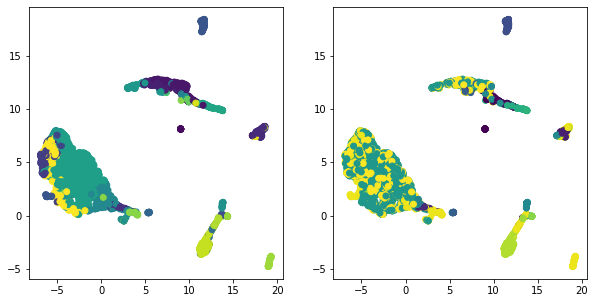

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
plt.sca(axes[0])
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=pred_f)

plt.sca(axes[1])
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=labels_f)

In [64]:
from sklearn.metrics import classification_report

In [66]:
print(classification_report(y_true=labels_f, y_pred=pred_f))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.93      0.72      0.81        18
           2       0.22      0.50      0.31       108
           3       0.00      0.00      0.00         1
           4       0.58      0.93      0.71        57
           5       0.45      0.76      0.57        25
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.70      1.00      0.82        73
          10       0.00      0.00      0.00         0
          11       0.65      0.85      0.74        20
          12       0.00      0.00      0.00         0
          13       0.50      0.08      0.14        12
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.02      0.57      0.04         7
          17       0.53    